In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    parser.add_argument('--ckpt_dir', default=None, type=str)
    return parser

def get_transforms(is_3D):
        transforms = [
            LabelSelect(label_id=1),
            RandomFlip(p=0.5, orientation="horizontal"),
            # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
            # GaussianNoise(p=0.2, mean=0, sigma=0.2),
            # RandomAffine(p=0.2, shear=(.1,3.)),
            # RandomAffine(p=0.2, degrees=5),
            RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))


            #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
        ]
        if not is_3D:
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        else:
            transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        
def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test
    
class StandardLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred




strawberry


In [2]:

ckpt_dir = "test"
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

test_proportion = 0.1
validation_proportion = 0.2
seed = 3407

# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

print(len(train_dataset), len(val_dataset), len(test_dataset))

# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)



8743 2497 1248


In [3]:
model_raw = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 })

In [13]:
import torch.nn as nn
import torch
from torchmetrics import Metric

def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss_reweighted(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def orig_dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    return torch.mean(combined)

In [14]:
loss = dice_loss

optimizer_params={"lr":1e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[20,50,80], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

# model = StandardLitModelWrapper(model_raw, dice_loss_reweighted, 
#                                 logging_metric=lambda : None,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )

ckpt = "/home/s2208943/ipdis/results/final_models/ensemble12/epoch=32-step=4521.ckpt"
model = StandardLitModelWrapper.load_from_checkpoint(ckpt, model=model_raw, loss=orig_dice_loss, 
                                logging_metric=lambda : None
                               )

In [15]:
accelerator="gpu"
devices=1
max_epochs=30
precision = 32

rootdir = "/disk/scratch/s2208943/results/final_models/"
final_dir = rootdir + ckpt_dir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=20, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
#trainer.fit(model, train_dataloader, val_dataloader)

In [17]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.25119683146476746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.25119683146476746}]

In [11]:
with torch.no_grad():
    x, y = next(iter(val_dataloader))
    out = model(x.to(model.device))

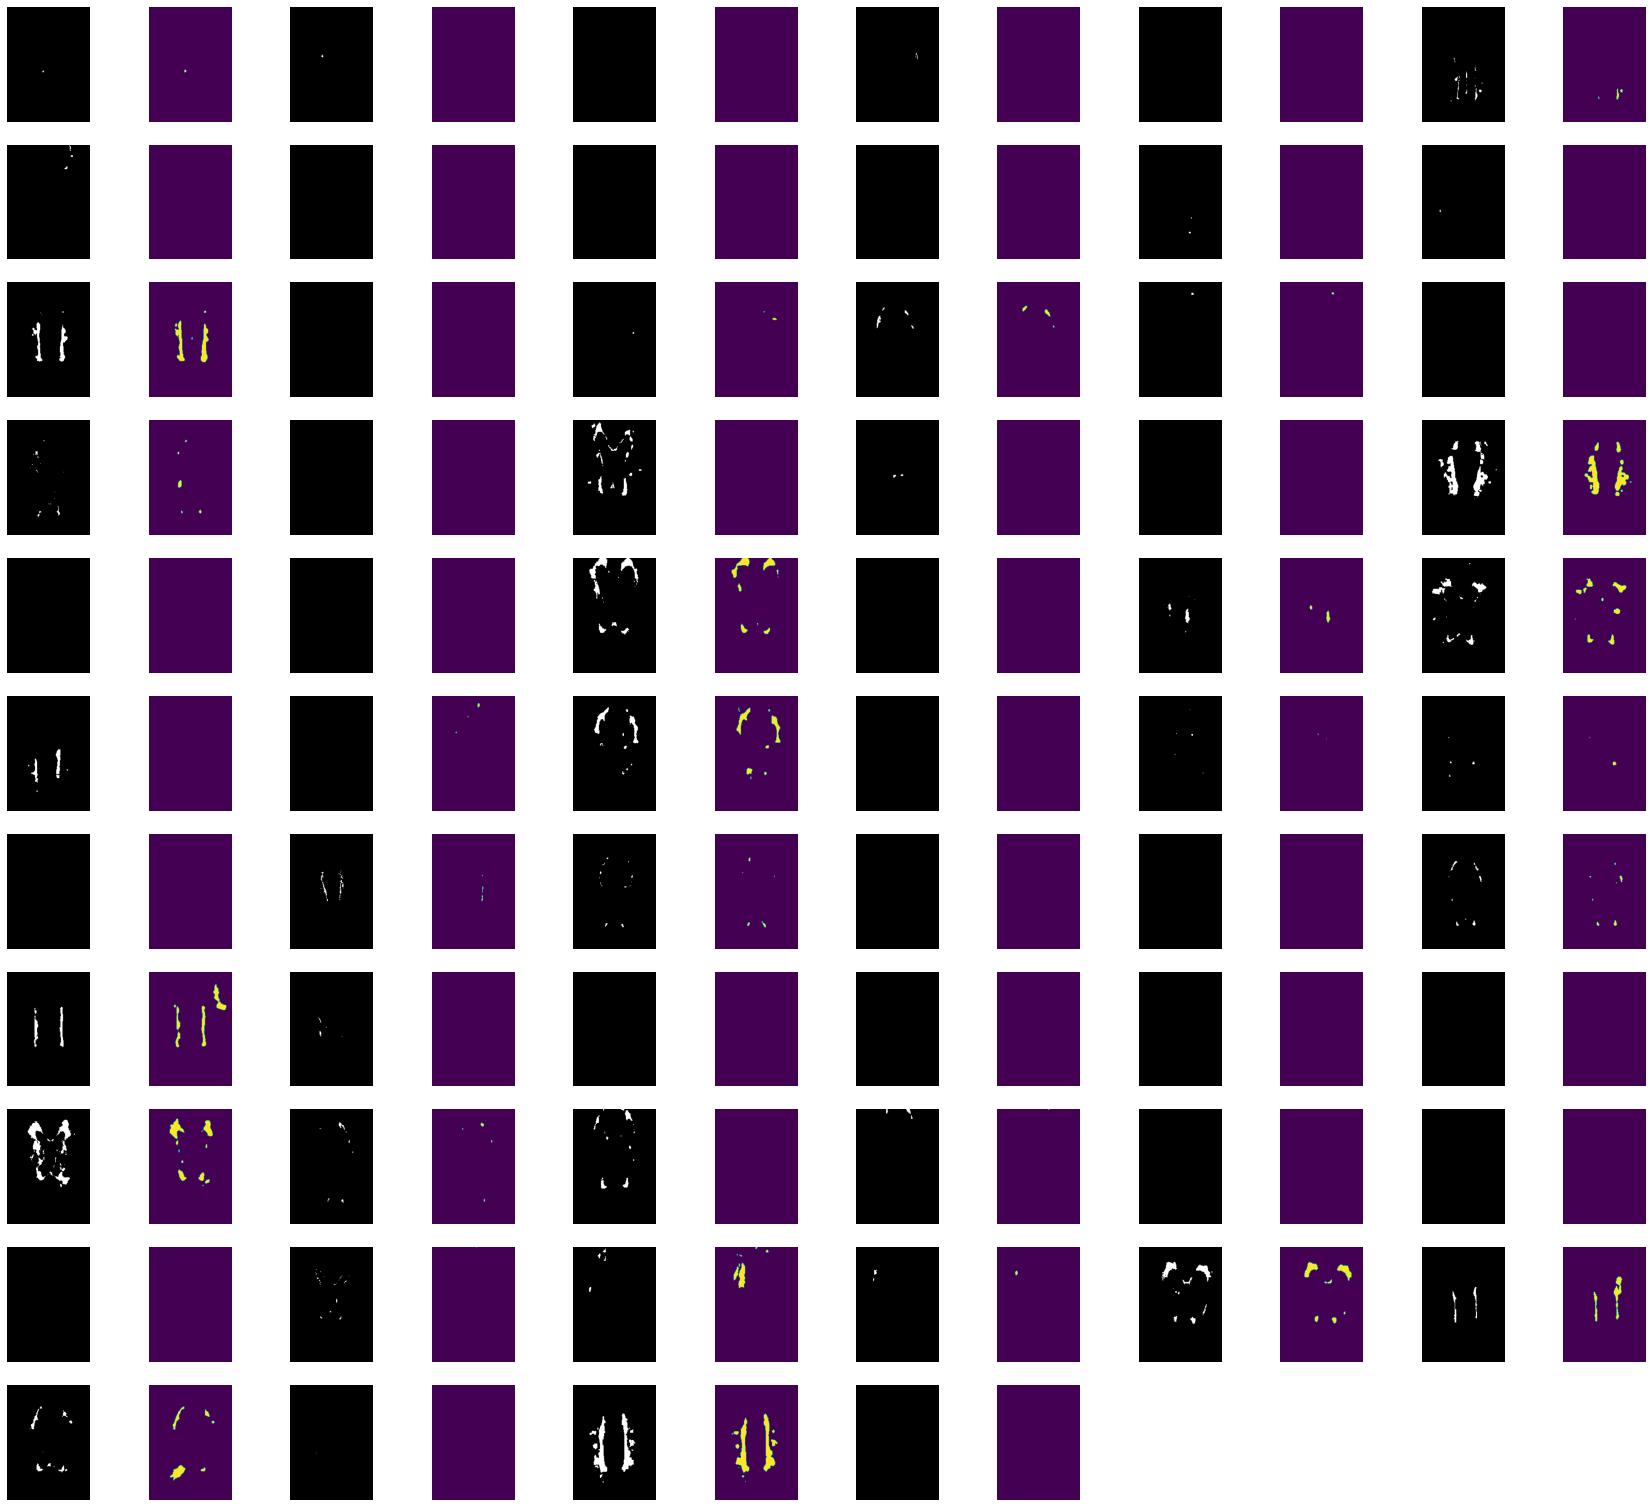

In [12]:
count = 0
plt.figure(figsize=(30,30))
for i in range(len(y)):
    plt.subplot(12, 12, count+1)
    plt.imshow(y[i], cmap='gray'); plt.axis('off')
    plt.subplot(12, 12, count+2)
    plt.imshow(out[i].cpu().argmax(dim=0)); plt.axis('off')
    count += 2